# Introduction to pycalphad

## Databases
Any calculation in pycalphad requires you to define:
* A Database
* The components to consider
* The phases to consider
* The conditions of the calculation

CALPHAD database files are made by researchers who model the Gibbs energy functions. The parameters (Gibbs energy functions) in the databases are stored in the Thermodynamic DataBase (TDB) format. Files are usually saved with the file extension .tdb. These files are read by pycalphad by importing the Database class and running the following

```python
from pycalphad import Database
db = Database("path/to/database.tdb")
```

Many database files have been indexed at the [TDBDB](https://avdwgroup.engin.brown.edu/), which can be used to search for TDB files. Many binary and ternary systems have been evaluated, some more than once as new data or calculations are published.

For the following examples, the TDB files have been provided for you in the `databases/` folder.

# Calculate and Plot Activity


Given an existing database for Al-Zn, we would like to calculate the activity of the liquid.

## Experimental activity results

In order to make sure we are correct, we'll compare the values with experimental results.
Experimental activities are digtized from Fig 18 in A. Yazawa, Y.K. Lee, Thermodynamic Studies of the Liquid Aluminum Alloy Systems, Trans. Japan Inst. Met. 11 (1970) 411–418. https://doi.org/10.2320/matertrans1960.11.411.

The measurements are at 1073 K and they used a reference state of the pure Zn at that temperature.


In [1]:
exp_x_zn =   [0.0482, 0.1990, 0.3550, 0.5045, 0.6549, 0.8070, 0.9569]
exp_acr_zn = [0.1154, 0.3765, 0.5411, 0.6433, 0.7352, 0.8384, 0.9531]

## Set up the database

Al-Zn database is taken from S. Mey, Reevaluation of the Al-Zn system, Zeitschrift F{ü}r Met. 84 (1993) 451–455.

In [2]:
from pycalphad import Database, equilibrium, variables as v
import numpy as np

dbf = Database('databases/alzn_mey.tdb') 

comps = ['AL', 'ZN', 'VA']
phases = list(dbf.phases.keys())
temp = 1073

## Calculate the reference state

Because all chemical activities must be specified with a reference state, we're going to choose a reference state as the pure element at the same temperature, consistent with the experimental data.

In [3]:
ref_eq = equilibrium(dbf, comps, phases, {v.P: 101325, v.T: temp, v.X('ZN'): 1})

/opt/conda/lib/python3.8/site-packages/pycalphad/core/lower_convex_hull.py:136: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum


## Calculate the equilibria

Do the calculation over the composition range

In [4]:
eq = equilibrium(dbf, comps, phases, {v.P: 101325, v.T: temp, v.X('ZN'): (0, 1, 0.005)})

## Get the chemical potentials and calculate activity

We need to select the chemical potentials from the xarray Dataset and calculate the activity.

In [5]:
chempot_ref = ref_eq.MU.sel(component='ZN').squeeze()
chempot = eq.MU.sel(component='ZN').squeeze()

acr_zn = np.exp((chempot - chempot_ref)/(8.315*temp))

## Plot the result

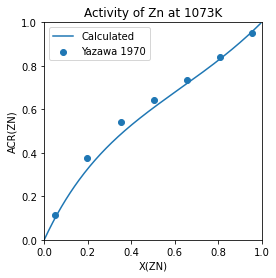

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eq.X.sel(component='ZN', vertex=0).squeeze(), acr_zn, label='Calculated')
# add experimental data
plt.scatter(exp_x_zn, exp_acr_zn, label='Yazawa 1970')

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().set_aspect(1)
plt.xlabel('X(ZN)')
plt.ylabel('ACR(ZN)')
plt.title('Activity of Zn at {0}K'.format(temp))
plt.legend(loc=0)